In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import arviz as az
import seaborn as sns

from REStats.utils import load_SCADA, transform, inv_transform, downsample
from REStats.circular_metrics import circular_rmse, circular_mae, circular_mean
from REStats.models import fit_weibull, persistence_wind_speed, backtest, persistence_wind_dir
from REStats.plots import save_figs
from REStats.models.weibull import plot_prior_samples

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [2]:
sns.set_theme()

In [3]:
wt = load_SCADA(2019)

In [4]:
SAVE_FIGS = True
figs = {}

# Wind -> Wind

This approach takes advantage of the fact that wind speeds follow a Weibull distribution. By fitting the curve to find the shape $\alpha$ and scale $\beta$ parameters, we can apply a transformation to make the curve more Gaussian, after which we can standardize the data before passing it to the model.

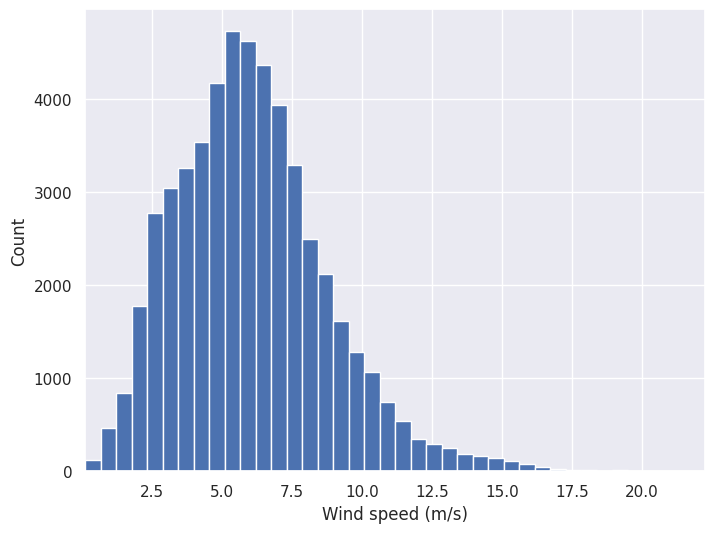

In [5]:
full_ws_hist, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Count")

b = ax.hist(wt.wind_speed, bins=40)

figs["full_ws_hist"] = full_ws_hist

In [6]:
wt_1m = wt[(wt.index >= "2019-02-01") & (wt.index < "2019-03-01")]

wt_ds = downsample(wt_1m) 

ws = wt_ds[["wind_speed"]]

/home/cam/workspace/projects/REStats/REStats/utils.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["turbulence_intensity"] = df["wind_speed"].rolling(window=6).std() / df["wind_speed"].rolling(window=6).mean()


In [7]:
wt_ds.isnull().sum()

wind_speed              0
wind_dir                0
power                   0
turbulence_intensity    0
dtype: int64

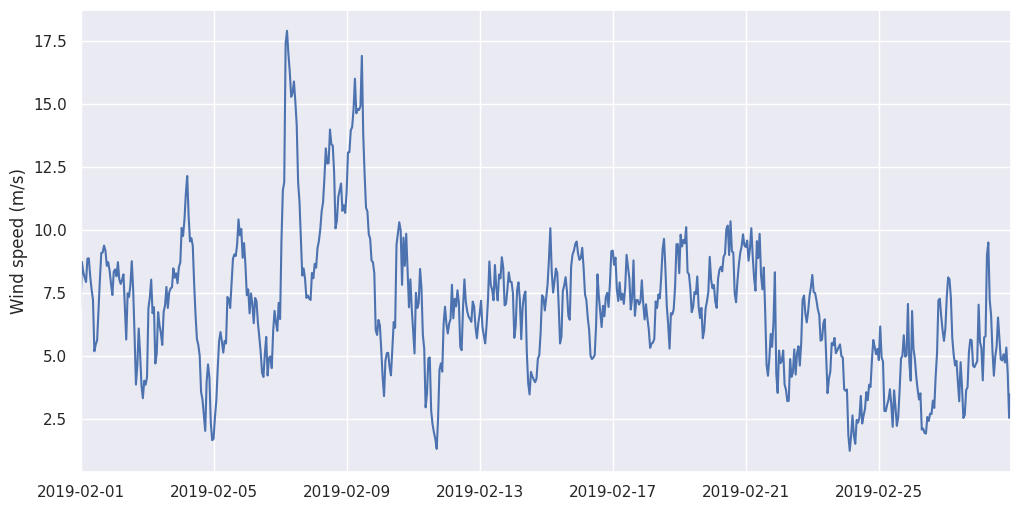

In [8]:
training_raw, ax = plt.subplots(figsize=(12, 6))

ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(wt_ds.index, wt_ds.wind_speed)

figs["training_raw"] = training_raw

## Processing: Weibull fit

In order to transform the wind speed distribution to be more Normal, fit the current distribution as Weibull using Bayesian Inference. The resulting shape parameter, $\alpha$, will be used to perform the transformation.

In [9]:
idata_wb = fit_weibull(wt_ds.wind_speed)

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [0]: 100%|█| 1500/1500 [00:29, 51.29it/s, step size=5.81e-01, acc. prob=0
Sample [1]: 100%|█| 1500/1500 [00:20, 72.56it/s, step size=8.16e-01, acc. prob=0


In [10]:
wt_ds.wind_speed.describe()

count    672.000000
mean       6.926740
std        2.713543
min        1.224047
25%        5.091319
50%        6.937040
75%        8.325460
max       17.903056
Name: wind_speed, dtype: float64

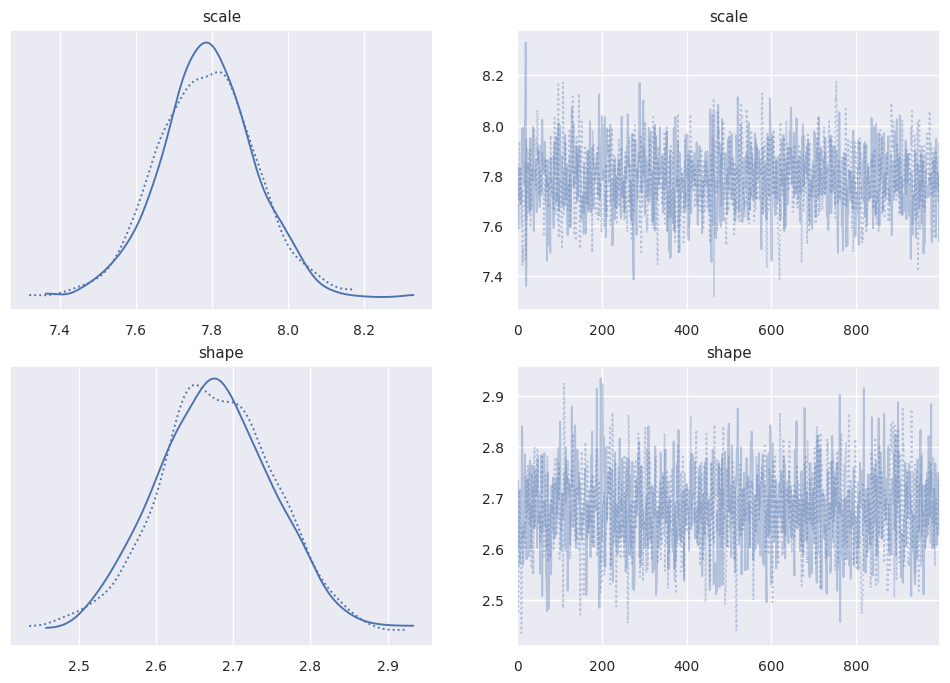

In [11]:
az.plot_trace(idata_wb, figsize=(12, 8))

wb_trace = plt.gcf()
figs["wb_trace"] = wb_trace

In [12]:
az.loo(idata_wb)

Computed from 2000 posterior samples and 672 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1615.58    21.19
p_loo        3.00        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      672  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [13]:
idata_wb

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

/home/cam/workspace/projects/REStats/REStats/models/weibull.py:102: RuntimeWarning: divide by zero encountered in power
  return (shape / scale) * (x / scale)**(shape - 1) * np.exp(-(x / scale)**shape)


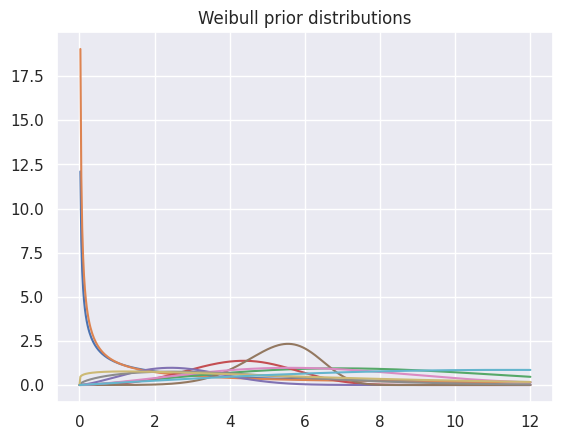

In [14]:
fig = plot_prior_samples(idata_wb)
    
figs["wb_prior"] = fig

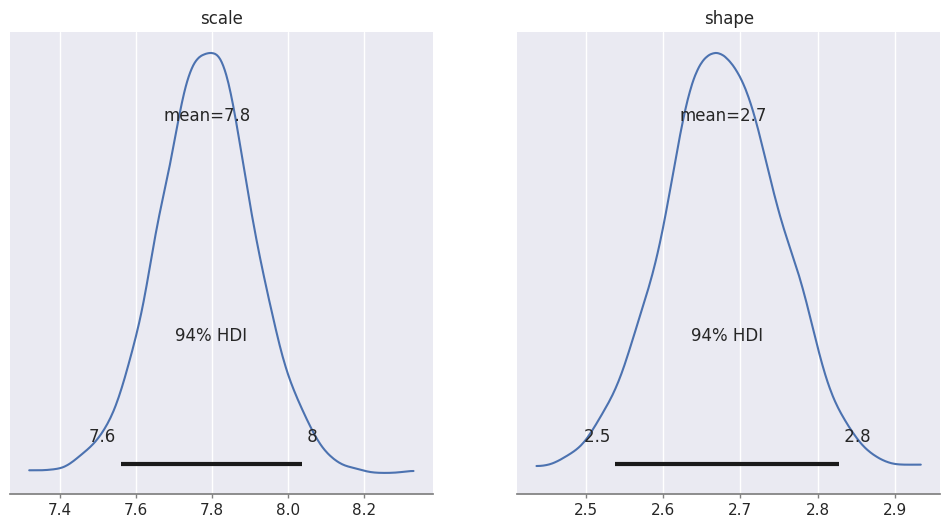

In [15]:
az.plot_posterior(idata_wb, figsize=(12, 6))

wb_posterior = plt.gcf()

figs["wb_posterior"] = wb_posterior

In [16]:
# wb_ppc, ax = plt.subplots(figsize=(8, 6))

# az.plot_ppc(idata_wb, ax=ax)
# ax.set_xlabel("Wind speed (m/s)")

# figs["wb_ppc"] = wb_ppc

We can use the fitted Weibull distribution's shape parameter $\alpha$ to apply a transform to our wind speed data $V$ to make it more Gaussian,

$$
\hat{V} = V^m
$$

where

$$
m = \frac{\alpha}{3.6}
$$

Why 3.6? This is the shape parameter corresponding to a Weibull distribution with Gaussian shape.

In [17]:
shape = idata_wb.posterior.shape.mean(["chain", "draw"]).item(0)
scale = idata_wb.posterior.scale.mean(["chain", "draw"]).item(0)

m = shape / 3.6

print(f"m: {m}")

m: 0.7437397190921314


In [18]:
ws_tf, hr_stats = transform(ws, m)

ws_tf.head()

,wind_speed,v_scaled,v,hr,v_scaled_std
Date,,,,,
2019-02-01 00:00:00,6.851252,4.184035,6.851252,0,-0.017755
2019-02-01 01:00:00,8.726291,5.008785,8.726291,1,0.667099
2019-02-01 02:00:00,8.323363,4.835738,8.323363,2,0.474776
2019-02-01 03:00:00,8.106309,4.741633,8.106309,3,0.336633
2019-02-01 04:00:00,7.925400,4.662703,7.925400,4,0.198691


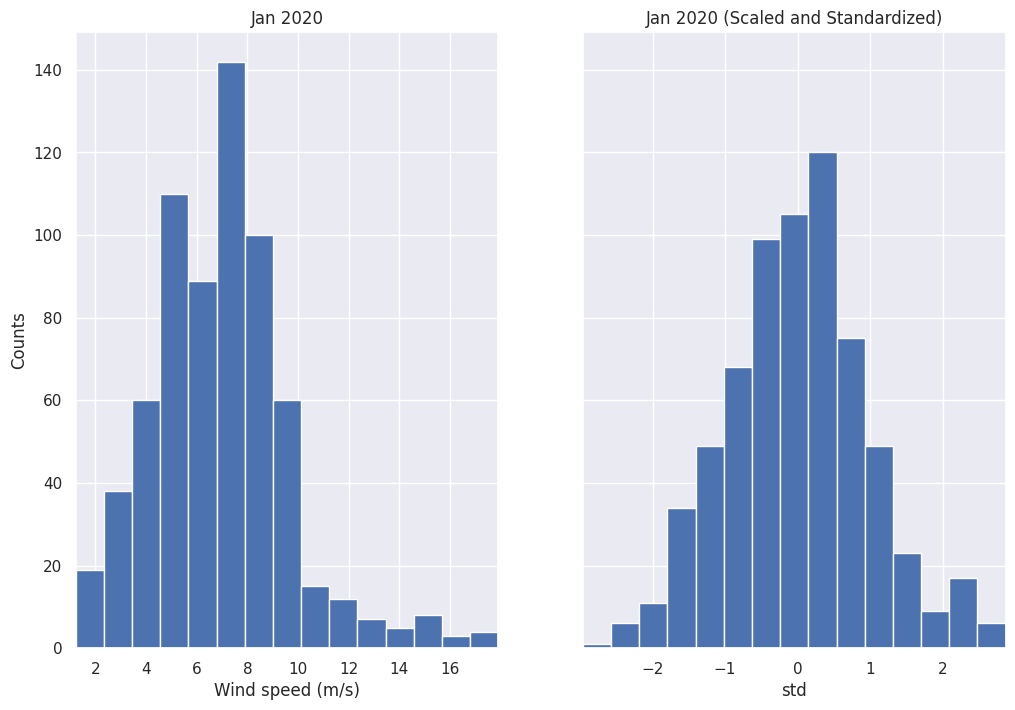

In [19]:
ws_hist_std_comparison, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

[ax.set_xmargin(0) for ax in axes]
axes[0].set_ylabel("Counts")
axes[0].hist(ws_tf.v, bins=15)
axes[0].set_title("Jan 2020")
axes[0].set_xlabel("Wind speed (m/s)")
axes[1].hist(ws_tf.v_scaled_std, bins=15)
axes[1].set_title("Jan 2020 (Scaled and Standardized)")
axes[1].set_xlabel("std")

figs["ws_hist_std_comparison"] = ws_hist_std_comparison

## Modeling

Autoregressive Moving Average (ARMA) models combine autoregression (AR) and moving average (MA) terms in order to best fit the time series. The ARMA(2, 2) model has been shown in the literature to be highly competitive for short-term wind speed forecasting, though other combinations of p (AR lags) and q (MA lags) may prove better depending on the situation.

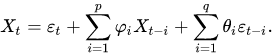

The data transformation includes both the scaling based on Weibull fit, as well as standardization based on mean/std wind speeds for given hours of the day, which helps remove diurnal nonstationarity.

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


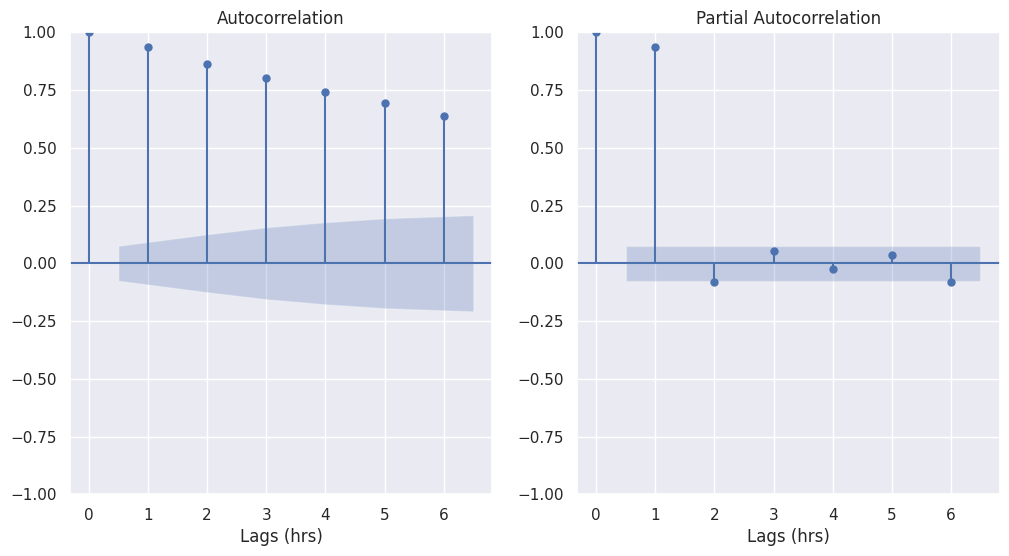

In [20]:
autocorrelation, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_xlabel("Lags (hrs)")
axes[1].set_xlabel("Lags (hrs)")

autocorrelation = plot_acf(wt_ds.wind_speed, lags=6, ax=axes[0])
autocorrelation = plot_pacf(wt_ds.wind_speed, lags=6, ax=axes[1])

figs["acf_ws"] = autocorrelation

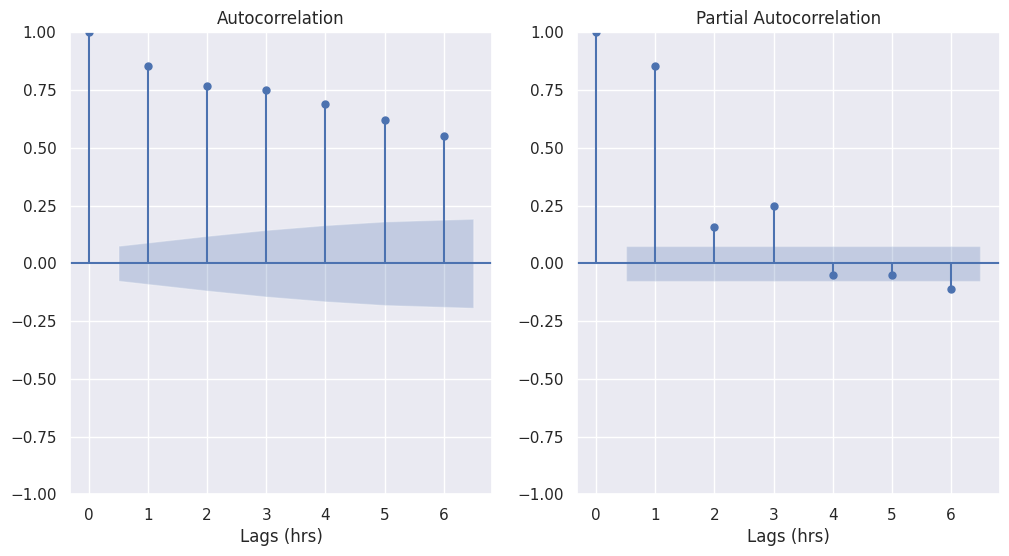

In [21]:
autocorrelation, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_xlabel("Lags (hrs)")
axes[1].set_xlabel("Lags (hrs)")

autocorrelation = plot_acf(wt_ds.wind_dir, lags=6, ax=axes[0])
autocorrelation = plot_pacf(wt_ds.wind_dir, lags=6, ax=axes[1])

figs["acf_wind_dir"] = autocorrelation

In [22]:
# Forecast wind_dir using the persistence method
steps_ahead = 1
wind_dir_forecast = persistence_wind_dir(wt_ds, steps_ahead)

# Calculate RMSE and MAE for the wind_dir persistence method predictions
wind_dir_rmse = circular_rmse(wt_ds["wind_dir"][steps_ahead:], wind_dir_forecast.dropna())
wind_dir_rmse_rel = wind_dir_rmse / circular_mean(wt_ds["wind_dir"][steps_ahead:]) * 100
wind_dir_mae = circular_mae(wt_ds["wind_dir"][steps_ahead:], wind_dir_forecast.dropna())

# Print the RMSE and MAE values
print(f"Wind direction RMSE: {wind_dir_rmse} deg")
print(f"Wind direction RMSE (%): {wind_dir_rmse_rel}")
print(f"Wind direction MAE: {wind_dir_mae} deg")

Wind direction RMSE: 12.979217756324138 deg
Wind direction RMSE (%): 6.071495871305177
Wind direction MAE: 8.061766490596876 deg


In [23]:
arma_mod = ARIMA(ws_tf.v_scaled_std, order=(2, 0, 2), trend="n")
arma_res = arma_mod.fit()
print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:           v_scaled_std   No. Observations:                  672
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -272.586
Date:                Tue, 18 Apr 2023   AIC                            555.173
Time:                        17:42:53   BIC                            577.724
Sample:                    02-01-2019   HQIC                           563.906
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4979      0.270      1.842      0.065      -0.032       1.028
ar.L2          0.4086      0.245      1.668      0.095      -0.072       0.889
ma.L1          0.4615      0.271      1.706      0.0

In [24]:
pred = arma_res.get_prediction().summary_frame()
pred = pred.copy()
pred

v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2019-02-01 00:00:00,0.000000,0.982943,-1.926533,1.926533
2019-02-01 01:00:00,-0.016488,0.364681,-0.731249,0.698273
2019-02-01 02:00:00,0.634919,0.364574,-0.079632,1.349471
2019-02-01 03:00:00,0.376844,0.363048,-0.334716,1.088404
2019-02-01 04:00:00,0.356985,0.362694,-0.353883,1.067853
...,...,...,...,...
2019-02-28 19:00:00,-0.615696,0.362467,-1.326119,0.094726
2019-02-28 20:00:00,-1.104077,0.362467,-1.814500,-0.393655
2019-02-28 21:00:00,-0.804075,0.362467,-1.514497,-0.093653


Reverse the transformations for error calculations and plotting.

In [25]:
inv_pred = inv_transform(pred, m, hr_stats)
arma_rmse = mean_squared_error(ws_tf.v, inv_pred["mean"], squared=False)
arma_rmse_rel = arma_rmse/ws_tf.v.mean()*100

arma_mae = mean_absolute_error(ws_tf.v, inv_pred["mean"])

print(f"ARMA(2, 2) RMSE: {arma_rmse} m/s")
print(f"ARMA(2, 2) RMSE (%): {arma_rmse_rel}")
print(f"ARMA(2, 2) MAE: {arma_mae} m/s")

ARMA(2, 2) RMSE: 0.9223867849021903 m/s
ARMA(2, 2) RMSE (%): 13.316319635370332
ARMA(2, 2) MAE: 0.7127462203701675 m/s


In [26]:
per = ws_tf.v.shift(1).bfill()
per_rmse = mean_squared_error(ws_tf.v, per, squared=False)
per_rmse_rel = per_rmse/ws_tf.v.mean()*100
per_mae = mean_absolute_error(ws_tf.v, per)

print(f"PER RMSE: {per_rmse} m/s", per_rmse)
print(f"PER RMSE (%): {per_rmse_rel}")
print(f"PER MAE: {per_mae} m/s")

PER RMSE: 0.9755607840147397 m/s 0.9755607840147397
PER RMSE (%): 14.083982377360604
PER MAE: 0.7487402425714988 m/s


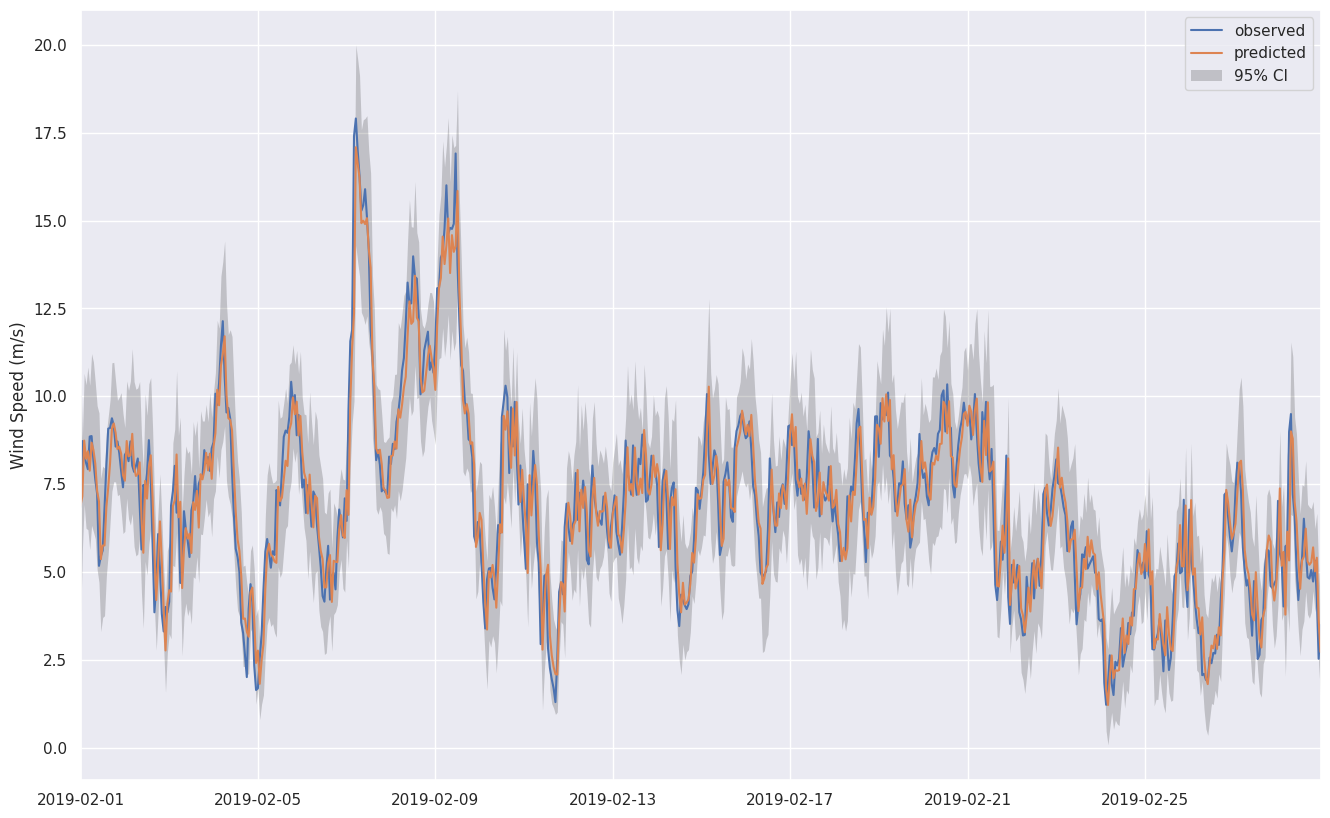

In [27]:
arma_fit_results, ax = plt.subplots(figsize=(16, 10))

ax.set_xmargin(0)
ax.set_ylabel("Wind Speed (m/s)")

ax.plot(ws_tf.index, ws_tf.v, label="observed")

ax.plot(inv_pred.index, inv_pred["mean"], label="predicted")
ax.fill_between(
    inv_pred.index, 
    inv_pred.mean_ci_lower, 
    inv_pred.mean_ci_upper, 
    color="k", alpha=.2, linewidth=0,
    label="95% CI"
)

ax.legend()

figs["arma_fit_results"] = arma_fit_results

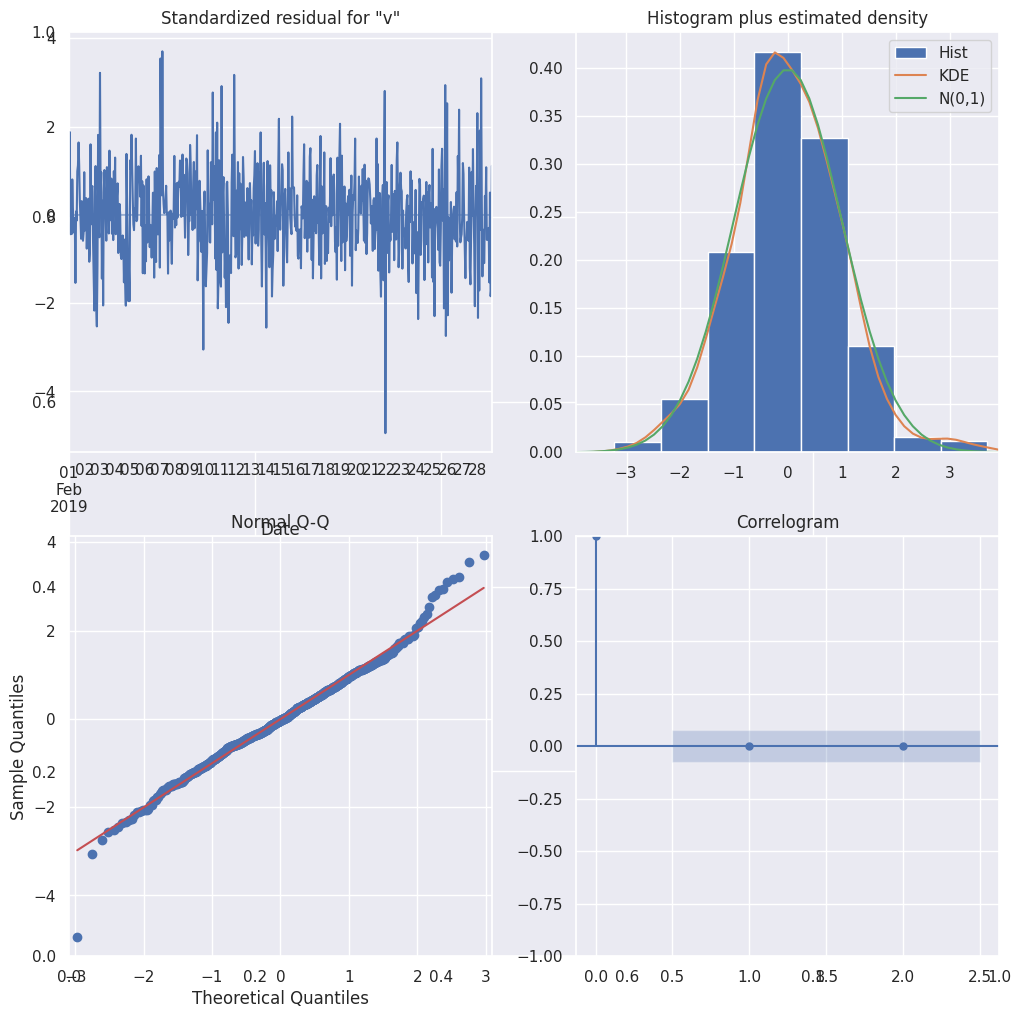

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))

f = arma_res.plot_diagnostics(fig=fig, lags=2)

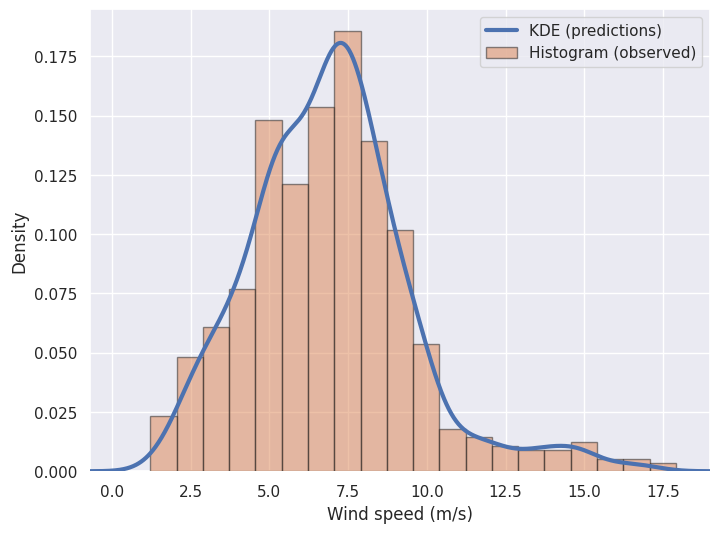

In [29]:
kde = sm.nonparametric.KDEUnivariate(inv_pred["mean"])
kde.fit()  # Estimate the densities

arma_fit_kde, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Density")

ax.plot(kde.support, kde.density, lw=3, label="KDE (predictions)", zorder=10)
ax.hist(
    ws_tf.v,
    bins=20,
    density=True,
    label="Histogram (observed)",
    zorder=5,
    edgecolor="k",
    alpha=0.5,
)
ax.legend()

figs["arma_fit_kde"] = arma_fit_kde

## Forecast

In [30]:
wt_t = wt[(wt.index >= "2020-03-01") & (wt.index < "2020-04-01")].copy()
wt_t.isnull().sum()

power         0.0
wind_dir      0.0
wind_speed    0.0
dtype: float64

In [31]:
wt_train = wt[(wt.index >= "2019-02-01") & (wt.index < "2019-03-01")].copy()
wt_test = wt[(wt.index >= "2019-03-01") & (wt.index < "2019-04-01")].copy()

v_train = wt_train[["wind_speed"]].resample("H").mean()
assert v_train["wind_speed"].isnull().sum() == 0 # sanity check
v_test = wt_test[["wind_speed"]].resample("H").mean()
assert v_test["wind_speed"].isnull().sum() == 0 # sanity check

In [32]:
forecasts_full, _ = backtest(v_train, v_test)

forecasts_full.head()

/home/cam/workspace/projects/REStats/env/lib/python3.10/site-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [0]: 100%|█| 1500/1500 [00:22, 66.07it/s, step size=6.85e-01, acc. prob=0
Sample [1]: 100%|█| 1500/1500 [00:15, 96.42it/s, step size=7.19e-01, acc. prob=0


Forecast RMSE: 1.1149953352496627 m/s
Forecast RMSE (%): 14.624527186648372
Forecast MAE: 0.8302910707437426 m/s


v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-03-01 01:00:00,3.154323,8.017698,1.940881,4.503634
2019-03-01 02:00:00,4.036200,8.034709,2.592927,5.628067
2019-03-01 03:00:00,2.487306,8.180127,1.116216,4.095965
2019-03-01 04:00:00,4.726517,8.454752,2.847794,6.823745
2019-03-01 05:00:00,6.421442,8.532474,4.305310,8.736199


In [33]:
persistence_wind_speed(v_test["wind_speed"])

PER RMSE: 1.0665964958934706 m/s
PER RMSE (%): 13.989717228624315
PER MAE: 0.787914913415891 m/s


(1.0665964958934706, 0.787914913415891)

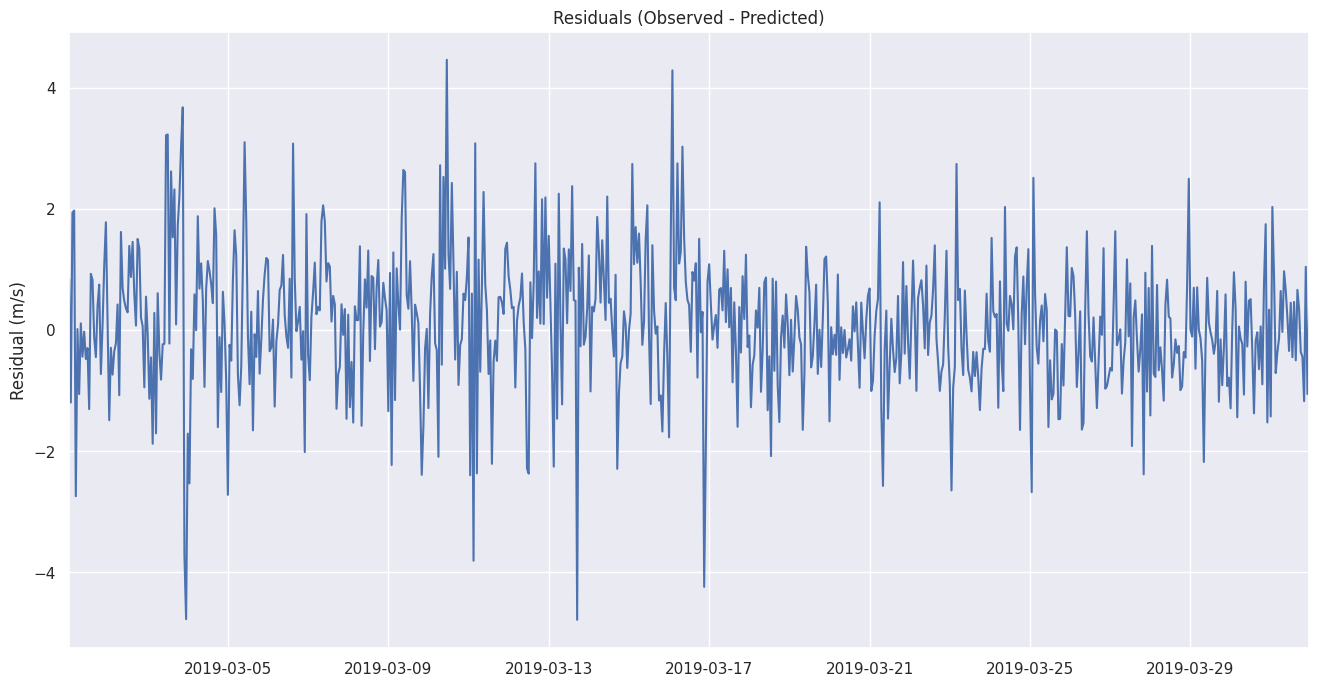

In [34]:
arma_forecast_resid, ax = plt.subplots(figsize=(16, 8))
ax.set_ylabel("Residual (m/s)")
ax.set_xmargin(0)
ax.set_title("Residuals (Observed - Predicted)")

resid = v_test["wind_speed"][1:] - forecasts_full["mean"]

ax.plot(forecasts_full.index, resid)

figs["arma_forecast_resid"] = arma_forecast_resid

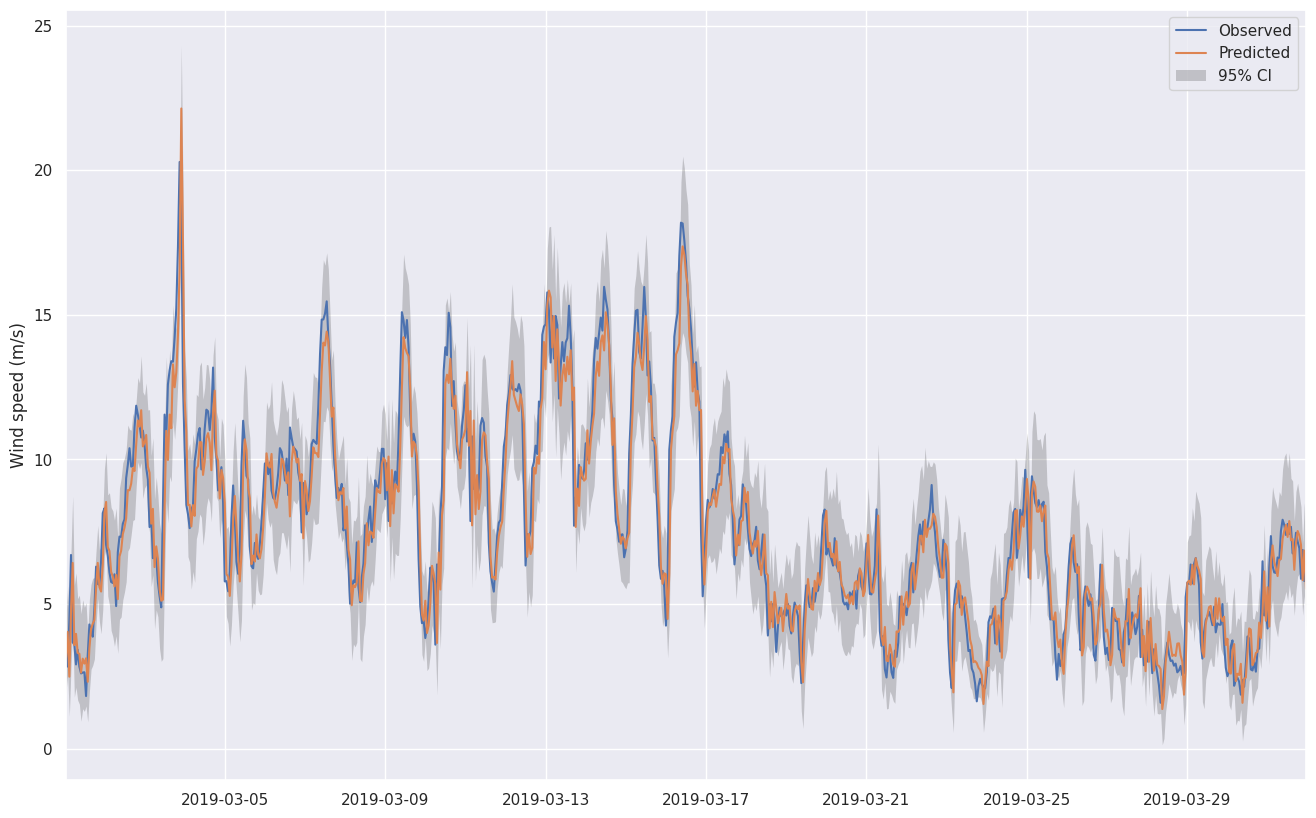

In [35]:
arma_forecast_results, ax = plt.subplots(figsize=(16, 10))
ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(v_test.index[1:], v_test[1:], label="Observed")
ax.plot(forecasts_full.index, forecasts_full["mean"], label="Predicted")


ax.fill_between(
    forecasts_full.index, 
    forecasts_full.mean_ci_lower, 
    forecasts_full.mean_ci_upper,
    color="k", alpha=.2, linewidth=0, label="95% CI"
)

ax.legend()

figs["arma_forecast_results"] = arma_forecast_results

In [36]:
if SAVE_FIGS:
    save_figs(figs)